In [1]:
import os
import torch
import glob
import random
import numpy as np
import cv2
import torchvision.datasets as datasets
from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10
from torchvision.datasets import ImageFolder
from PIL import Image
import argparse
from mmcv import Config
from src.experiments import ExpMvtec
import torchvision.transforms as transforms

In [2]:
parser = argparse.ArgumentParser()

parser.add_argument('--config_file', default ='./configs/config_mvtec.py', help='the path of config file')
parser.add_argument('--path', '--checkpoints', type=str, default='./checkpoints', help='model checkpoints path (default: ./checkpoints)')
parser.add_argument('--dataset', type=str, default = 'MVTecAD', help='Dataset name:CIFAR|MvtecAD')
parser.add_argument('--subset', type=str, help='subset name (default: None)')
parser.add_argument('--gpu', type=str, help='gpu list')
parser.add_argument('--input', type=str, help='path to the input images directory or an input image')
parser.add_argument('--val', type=str, help='path to the val images directory')
parser.add_argument('--mask', type=str, help='path to the masks directory or a mask file')
parser.add_argument('--output', type=str, help='path to the output directory')
parser.add_argument('--debug', type=int, help='if not 0 will save debug image')
parser.add_argument('--stage', type=int, help='if not 0 will save debug image')

args = parser.parse_args([])

In [3]:
args.subset = 'bottle'
args

Namespace(config_file='./configs/config_mvtec.py', dataset='MVTecAD', debug=None, gpu=None, input=None, mask=None, output=None, path='./checkpoints', stage=None, subset='bottle', val=None)

In [4]:
from mmcv import Config

config = Config.fromfile('./configs/config_mvtec.py')
config

Config (path: ./configs/config_mvtec.py): {'MODE': 1, 'MASK_TYPE': 3, 'SEED': 10, 'GPU': [0], 'DEBUG': 0, 'VERBOSE': 0, 'dataroot': './dataset/mvtec', 'workers': 4, 'normal_class': 'good', 'TRAIN_MASK_FLIST': './mask', 'TEST_MASK_FLIST': './mask', 'LR': 0.0001, 'D2G_LR': 0.1, 'BETA1': 0.0, 'BETA2': 0.9, 'BATCH_SIZE': 4, 'INPUT_SIZE': 512, 'INPUT_CHANNELS': 3, 'SCALES': [1, 2, 3], 'MAX_EPOCHS': 200, 'REC_LOSS_WEIGHT': 1, 'FM_LOSS_WEIGHT': 0, 'INPAINT_ADV_LOSS_WEIGHT': 0.001, 'GAN_LOSS': 'nsgan', 'LOG_INTERVAL': 10, 'STAGE': [1], 'DATASET': 'MvTecAD', 'SUB_SET': '', 'PATH': './ckpt/mvtec'}

In [5]:
if args.dataset is not None :
    config.DATASET = 'MVTecAD'
config

Config (path: ./configs/config_mvtec.py): {'MODE': 1, 'MASK_TYPE': 3, 'SEED': 10, 'GPU': [0], 'DEBUG': 0, 'VERBOSE': 0, 'dataroot': './dataset/mvtec', 'workers': 4, 'normal_class': 'good', 'TRAIN_MASK_FLIST': './mask', 'TEST_MASK_FLIST': './mask', 'LR': 0.0001, 'D2G_LR': 0.1, 'BETA1': 0.0, 'BETA2': 0.9, 'BATCH_SIZE': 4, 'INPUT_SIZE': 512, 'INPUT_CHANNELS': 3, 'SCALES': [1, 2, 3], 'MAX_EPOCHS': 200, 'REC_LOSS_WEIGHT': 1, 'FM_LOSS_WEIGHT': 0, 'INPAINT_ADV_LOSS_WEIGHT': 0.001, 'GAN_LOSS': 'nsgan', 'LOG_INTERVAL': 10, 'STAGE': [1], 'DATASET': 'MVTecAD', 'SUB_SET': '', 'PATH': './ckpt/mvtec'}

## 🎭 **Multi-scale striped masks**
- directions : horizontal, vertical (2가지)
- width : scale (4가지)

총 8가지의 조합*2(반전)으로 구성되며 **multi-scale mask** 생성

In [72]:
flist = glob.glob(config.TRAIN_MASK_FLIST + '/*.png')
flist

['./mask/512_4_2.png',
 './mask/512_4_1.png',
 './mask/512_4_3.png',
 './mask/512_8_2.png',
 './mask/512_2_1.png',
 './mask/512_1_2.png',
 './mask/512_2_0.png',
 './mask/512_2_3.png',
 './mask/512_2_2.png',
 './mask/512_4_0.png',
 './mask/512_8_1.png',
 './mask/512_1_3.png',
 './mask/512_1_0.png',
 './mask/512_8_0.png',
 './mask/512_1_1.png',
 './mask/512_8_3.png']

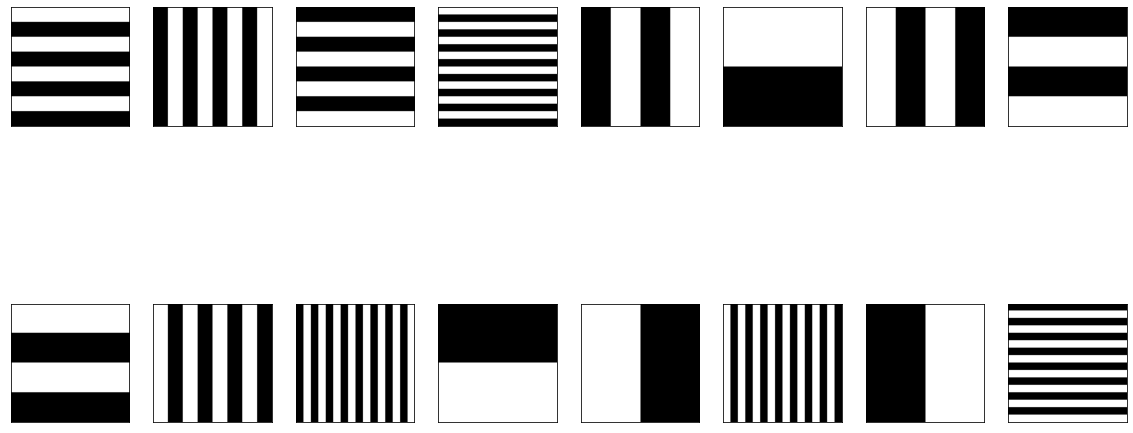

In [73]:
import glob
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (20,10))
plt.tight_layout()
cols = 8
rows = 2
i = 1

for filename in flist:
    img = cv2.imread(filename)
    ax = fig.add_subplot(rows, cols, i)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_xticks([]), ax.set_yticks([])
    i += 1
plt.show()

In [6]:
# any mode
# if args.dataset is not None:
#     config.append('DATASET', args.dataset)

if args.subset is not None:
    config.SUB_SET = args.subset
if args.gpu is not None:
    config.GPU = list(args.gpu)
if args.stage is not None:
    config.STAGE = [args.stage]

if config.SUB_SET is not None:
    config.SUB_SET = str(config.SUB_SET)
    config.PATH = os.path.join(config.PATH, config.SUB_SET)

# create checkpoints path if does't exist
if not os.path.exists(config.PATH):
    os.makedirs(config.PATH)

In [7]:
config

Config (path: ./configs/config_mvtec.py): {'MODE': 1, 'MASK_TYPE': 3, 'SEED': 10, 'GPU': [0], 'DEBUG': 0, 'VERBOSE': 0, 'dataroot': './dataset/mvtec', 'workers': 4, 'normal_class': 'good', 'TRAIN_MASK_FLIST': './mask', 'TEST_MASK_FLIST': './mask', 'LR': 0.0001, 'D2G_LR': 0.1, 'BETA1': 0.0, 'BETA2': 0.9, 'BATCH_SIZE': 4, 'INPUT_SIZE': 512, 'INPUT_CHANNELS': 3, 'SCALES': [1, 2, 3], 'MAX_EPOCHS': 200, 'REC_LOSS_WEIGHT': 1, 'FM_LOSS_WEIGHT': 0, 'INPAINT_ADV_LOSS_WEIGHT': 0.001, 'GAN_LOSS': 'nsgan', 'LOG_INTERVAL': 10, 'STAGE': [1], 'DATASET': 'MVTecAD', 'SUB_SET': 'bottle', 'PATH': './ckpt/mvtec/bottle'}

In [8]:
os.environ['CUDA_VISIBLE_DEVICES'] = ','.join(str(e) for e in config.GPU)

# init device
if torch.cuda.is_available():
    config.DEVICE = torch.device("cuda")
    torch.backends.cudnn.benchmark = True   # cudnn auto-tuner
else:
    config.DEVICE = torch.device("cpu")

# set cv2 running threads to 1 (prevents deadlocks with pytorch dataloader)
cv2.setNumThreads(0)

# initialize random seed
torch.manual_seed(config.SEED)
torch.cuda.manual_seed_all(config.SEED)
np.random.seed(config.SEED)
random.seed(config.SEED)

model = ExpMvtec(config)
model.load()

/home/sunwookim/.local/lib/python3.6/site-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


## ExpMvtec

In [74]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from src.models import InpaintingModel
from src.utils import Progbar
from src.metrics import PSNR
from src.evaluate import evaluate
from src.dataset import load_data, BlockMask

In [75]:
class ExpMvtec():
    def __init__(self, config):
        self.config = config

        model_name = 'coarse'
        if 2 in config.STAGE:
            model_name = 'fine'

        self.debug = False
        self.model_name = model_name
        self.epoch = 0
        self.inpaint_model = InpaintingModel(config).to(config.DEVICE)
        self.scale_norm = [1 for _ in range(len(config.SCALES))]

        self.psnr = PSNR(255.0).to(config.DEVICE)
        self.mask_set = BlockMask(config)
        self.dataset = load_data(config)
        mask_loader = DataLoader(dataset=self.mask_set, batch_size=1)
        self.masks = [x.to(self.config.DEVICE) for x in mask_loader]

        self.results_path = os.path.join(config.PATH, 'results')

        if hasattr(config, 'RESULTS'):
            self.results_path = os.path.join(config.RESULTS)

        if hasattr(config, 'DEBUG') and config.DEBUG != 0:
            self.debug = True

        self.log_file = os.path.join(config.PATH, 'log_' + model_name + '.dat')

    def load(self):
        self.inpaint_model.load()

    def save(self):
        self.inpaint_model.save()

    def train(self):
        train_loader = self.dataset['train']

        keep_training = True
        min_error = 1
        max_epoch = int(float(self.config.MAX_EPOCHS))
        total = len(train_loader.dataset)

        if total == 0:
            print('No training data was provided! Check \'TRAIN_FLIST\' value in the configuration file.')
            return

        while keep_training:
            if 1 in self.config.STAGE:
                self.inpaint_model.epoch += 1
                self.epoch = self.inpaint_model.epoch
                print('\n\nTraining proposal epoch: %d' % self.epoch)
                progbar = Progbar(total, width=20, stateful_metrics=['epoch', 'iter'])
                for items in train_loader:
                    self.inpaint_model.train()
                    images, masks, label = items
                    images, masks = self.cuda(images, masks)

                    # inpaint model
                    # train
                    outputs, gen_loss, dis_loss, logs = self.inpaint_model.process(images, masks)

                    # backward
                    self.inpaint_model.backward(gen_loss, dis_loss)

                    logs["epoch"] = self.epoch
                    logs["iter"] = self.inpaint_model.iteration

                    progbar.add(len(images), values=logs.items() if self.config.VERBOSE else [x for x in logs.items() if not x[0].startswith('l_')])

            # log model at checkpoints
            if self.config.LOG_INTERVAL and self.epoch % self.config.LOG_INTERVAL == 0:
                error1 = self.eval()
                auc1 = self.test()
                self.log([auc1, error1])
                if error1 <= min_error:
                    min_error = error1
                    self.save()

            if self.epoch >= max_epoch:
                break

        print('\nEnd training....')

    def eval(self):
        print('\n\nval:')
        val_loader = self.dataset['train4val']

        total = len(val_loader.dataset)
        self.inpaint_model.eval()

        mean_error = 0
        progbar = Progbar(total, width=20, stateful_metrics=['it'])
        for index, items in enumerate(val_loader):
            images, masks = self.cuda(*items[0:2])

            # inpaint model
            error1_list, mix_out_list_x, mix_out_list_y = self.get_error_map_for_some_scales(images, self.masks, metric='L1',
                                                                           scales=self.config.SCALES, output=True)
            error1 = self.get_max_select_error(error1_list)
            mean_error += torch.mean(error1) * len(items[0]) / total

            progbar.add(len(images), values=[('index', index)])
        return mean_error.item()

    def test(self):
        print('\n\ntest:')
        self.inpaint_model.eval()

        test_loader = self.dataset['test']

        total = len(test_loader.dataset)

        an_scores1 = torch.zeros(size=(total,), dtype=torch.float32, device=self.config.DEVICE)
        gt_labels = torch.zeros(size=(total,), dtype=torch.long, device=self.config.DEVICE)
        select_scale = torch.zeros(size=(total,), dtype=torch.long, device=self.config.DEVICE)
        progbar = Progbar(total, width=20, stateful_metrics=['it'])
        for index, items in enumerate(test_loader):
            start_index = index * test_loader.batch_size
            end_index = start_index + items[0].shape[0]
            images, masks, label = items
            images, masks = self.cuda(images, masks)

            # inpaint model
            error1_list, mix_out_list_x, mix_out_list_y = self.get_error_map_for_some_scales(images, self.masks, metric='MSE',
                                                                           scales=self.config.SCALES, output=True)
            error1, max_scale_ind = self.get_max_select_error(error1_list, need_arg=True)
            select_scale[start_index: end_index] = max_scale_ind
            an_scores1[start_index: end_index] = torch.mean(error1, [1, 2])
            gt_labels[start_index: end_index] = label
            progbar.add(len(images), values=[('index', index)])
        an_scores1 = (an_scores1 - torch.min(an_scores1)) / (torch.max(an_scores1) - torch.min(an_scores1))
        # metrics
        auc1 = evaluate(gt_labels, an_scores1)
        print(auc1)
        return auc1

    def get_error_map_coarse(self, images, mask_loader, metric='MSE'):
        if metric == 'MSE':
            error_metric = nn.MSELoss(reduction='none')
        else:
            error_metric = nn.L1Loss(reduction='none')
        with torch.no_grad():
            error = []
            raw_output = []
            sum_mask = []
            error_map_list = []
            for i, masks in enumerate(mask_loader):
                masks = masks.to(self.config.DEVICE)
                outputs = self.inpaint_model(images, masks)
                error.append(torch.mean(error_metric(outputs, images) * masks, 1))  # mean RGB channel
                raw_output.append(outputs * masks)
                sum_mask.append(masks)
            error = torch.stack(tuple(error))
            raw_output = torch.stack(tuple(raw_output))
            sum_mask = torch.stack(tuple(sum_mask))
            for index in range(0, self.config.SCALES*4, 4):
                sum_mask_t = sum_mask[index: index+4]
                sum_mask_t = torch.sum(sum_mask_t, 0)
                sum_mask_t = torch.reciprocal(sum_mask_t)
                sum_mask_t[sum_mask_t == float('inf')] = 0
                error_map_list.append(torch.sum(error[index: index+4] * sum_mask_t, 0))

            for i, error_map in enumerate(error_map_list):
                error_map_list[i] = error_map / self.scale_norm[i]
            error_map_merge = torch.stack(error_map_list)
            error_map_merge = torch.mean(error_map_merge, 0)
            # error_map_merge, _ = torch.max(error_map_merge, 0)
            mix_output = torch.sum(raw_output[0:4], 0)
        return error_map_merge, mix_output

    def get_error_map_for_some_scales(self, images, mask_loader, metric='MSE', scales=None, output=False):
        if metric == 'MSE':
            error_metric = nn.MSELoss(reduction='none')
        else:
            error_metric = nn.L1Loss(reduction='none')
        with torch.no_grad():
            error_map_list = []
            mix_output_x = []
            mix_output_y = []
            for scale in scales:
                error = []
                raw_output = []
                for masks in mask_loader[scale*4:(scale+1)*4]:
                    outputs = self.inpaint_model(images, masks)
                    if output:
                        raw_output.append(outputs*masks)
                    error.append(torch.mean(error_metric(outputs, images) * masks, 1))  # mean RGB channel
                if output:
                    raw_output = torch.stack(raw_output)
                    mix_output_x.append(torch.sum(raw_output[0:2], 0))
                    mix_output_y.append(torch.sum(raw_output[2:4], 0))
                error = torch.stack(tuple(error))
                # error_map_list.append(torch.sum(error * 0.5, 0))
                error_map_list.append(torch.max(error, 0)[0])

        return error_map_list, mix_output_x, mix_output_y


    def get_mean_merged_error(self, error_map_list):
        error_map_merge = torch.stack(error_map_list)
        error_map_merge = torch.mean(error_map_merge, 0)
        return error_map_merge

    def get_max_select_error(self, error_map_list, need_arg=False):
        error_map_list = torch.stack(error_map_list)
        mean_errors = torch.mean(error_map_list, (2, 3))
        for i, scale in enumerate(self.config.SCALES):
            # mean_errors[i] = mean_errors[i] / self.scale_norm[i]
            mean_errors[i] = mean_errors[i] - self.scale_norm[i]
        mean_errors, max_scale_ind = torch.max(mean_errors, dim=0)  # [batch]
        error_map_merge = torch.stack([error_map_list[j, i] for i, j in enumerate(max_scale_ind)])
        # error_map_merge = torch.mean(error_map_merge, 0)
        if need_arg:
            return error_map_merge, max_scale_ind
        else:
            return error_map_merge


    def get_error_map_coarse_center(self, images, mask_loader, metric='MSE'):
        if metric == 'MSE':
            error_metric = nn.MSELoss(reduction='none')
        else:
            error_metric = nn.L1Loss(reduction='none')
        error = 0
        raw_output = 0
        with torch.no_grad():
            for i, masks in enumerate(mask_loader):
                masks = masks.to(self.config.DEVICE)
                outputs = self.inpaint_model(images, masks)
                error = torch.mean(error_metric(outputs, images) * masks, 1)  # mean RGB channel
                raw_output = outputs * masks + images * (1-masks)

        return error, raw_output


    def update_norm(self):
        print('\n\nupdate normalization parameter:')
        val_loader = self.dataset['train4val']

        total = len(val_loader.dataset)
        self.inpaint_model.eval()

        mean_error_scales = {str(i): 0 for i in self.config.SCALES}
        progbar = Progbar(total, width=20, stateful_metrics=['it'])
        for index, items in enumerate(val_loader):
            images, masks = self.cuda(*items[0:2])
            # inpaint model
            error1_list, mix_out_list_x, mix_out_list_y = self.get_error_map_for_some_scales(images, self.masks, metric='MSE',
                                                                           scales=self.config.SCALES, output=True)
            for i, scale in enumerate(self.config.SCALES):
                mean_error_scales[str(scale)] += torch.mean(error1_list[i]) * len(items[0]) / total
            progbar.add(len(images), values=[('index', index)])
        # update
        for i, scale in enumerate(self.config.SCALES):
            self.scale_norm[i] = mean_error_scales[str(scale)].item()
        print('updated norm:', self.scale_norm)

    def log(self, logs):
        with open(self.log_file, 'a') as f:
            f.write('%s\n' % ' '.join([str(item) for item in logs]))

    def cuda(self, *args):
        return (item.to(self.config.DEVICE) for item in args)

    def postprocess(self, img):
        # [0, 1] => [0, 255]
        img = img * 255.0
        img = img.permute(0, 2, 3, 1)
        return img.int()

In [9]:
model.inpaint_model

InpaintingModel(
  (generator): InpaintGenerator(
    (encoder): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
      (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (3): ReLU(inplace=True)
      (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (11): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (12): ReLU(inplace=True)
    )
    (middle): Sequential(
      (0): ResnetBlock(
        (conv_block)

In [10]:
model.mask_set

In [11]:
model.masks[:3]

[tensor([[[[1., 1., 1.,  ..., 0., 0., 0.],
           [1., 1., 1.,  ..., 0., 0., 0.],
           [1., 1., 1.,  ..., 0., 0., 0.],
           ...,
           [1., 1., 1.,  ..., 0., 0., 0.],
           [1., 1., 1.,  ..., 0., 0., 0.],
           [1., 1., 1.,  ..., 0., 0., 0.]]]], device='cuda:0'),
 tensor([[[[0., 0., 0.,  ..., 1., 1., 1.],
           [0., 0., 0.,  ..., 1., 1., 1.],
           [0., 0., 0.,  ..., 1., 1., 1.],
           ...,
           [0., 0., 0.,  ..., 1., 1., 1.],
           [0., 0., 0.,  ..., 1., 1., 1.],
           [0., 0., 0.,  ..., 1., 1., 1.]]]], device='cuda:0'),
 tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')]

## Train

In [12]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from src.models import InpaintingModel
from src.utils import Progbar
from src.metrics import PSNR
from src.evaluate import evaluate
from src.dataset import load_data, BlockMask

In [13]:
inpaint_model = InpaintingModel(config).to(config.DEVICE)
inpaint_model

InpaintingModel(
  (generator): InpaintGenerator(
    (encoder): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
      (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (3): ReLU(inplace=True)
      (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (11): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (12): ReLU(inplace=True)
    )
    (middle): Sequential(
      (0): ResnetBlock(
        (conv_block)

In [15]:
scale_norm = [1 for _ in range(len(config.SCALES))]
scale_norm

[1, 1, 1]

- PSNR 

In [16]:
class PSNR(nn.Module):
    def __init__(self, max_val):
        super(PSNR, self).__init__()

        base10 = torch.log(torch.tensor(10.0))
        max_val = torch.tensor(max_val).float()

        self.register_buffer('base10', base10)
        self.register_buffer('max_val', 20 * torch.log(max_val) / base10)

    def __call__(self, a, b):
        mse = torch.mean((a.float() - b.float()) ** 2)

        if mse == 0:
            return torch.tensor(0)

        return self.max_val - 10 * torch.log(mse) / self.base10

In [17]:
psnr = PSNR(255.0).to(config.DEVICE)

- mask_set

In [19]:
import os
import torch
import glob
import random
import numpy as np
import torchvision.datasets as datasets
from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10
from torchvision.datasets import ImageFolder
from PIL import Image
import torchvision.transforms as transforms

class BlockMask(torch.utils.data.Dataset):
    def __init__(self, config):
        self.flist = list(glob.glob(config.TRAIN_MASK_FLIST + '/*.jpg')) + list(glob.glob(config.TRAIN_MASK_FLIST + '/*.png'))
        self.flist.sort()
        self.mask_set = []
        for mask_index in range(len(self.flist)):
            mask = Image.open(self.flist[mask_index])
            mask = transforms.Resize(config.INPUT_SIZE, Image.NEAREST)(mask)
            self.mask_set.append(transforms.ToTensor()(mask))

    def __len__(self):
        return len(self.flist)

    def __getitem__(self, index):
        return self.mask_set[index]

def load_data(opt):
    """ Load Data

    Args:
        opt ([type]): Argument Parser

    Raises:
        IOError: Cannot Load Dataset

    Returns:
        [type]: dataloader
    """

    ##
    masks = AddMask(opt)
    if opt.normal_class == '':
        opt.normal_class = opt.SUB_SET
    # LOAD DATA SET
    if opt.dataroot == '':
        opt.dataroot = './dataset/{}'.format(opt.DATASET)

    if opt.DATASET in ['MVTecAD']:
        if opt.SUB_SET is not None:
            opt.dataroot = os.path.join(opt.dataroot, opt.SUB_SET)
        splits = ['train', 'test', 'train4val']
        splits2folder = {'train': 'train', 'test': 'test', 'train4val': 'train'}
        drop_last_batch = {'train': True, 'test': False, 'train4val': False}
        shuffle = {'train': True, 'test': False, 'train4val': False}
        transform = transforms.Compose([transforms.Resize(opt.INPUT_SIZE),
                                        transforms.CenterCrop(opt.INPUT_SIZE),
                                        transforms.ToTensor(), ])
                                        # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), ])

        collate = {'train': masks.append_mask, 'test': masks.append_mask, 'train4val': masks.append_mask}
        dataset = {x: ImageFolder(os.path.join(opt.dataroot, splits2folder[x]), transform) for x in splits}


        dataset = {x: get_custom_anomaly_dataset(dataset[x], opt.normal_class) for x in dataset.keys()}
        # dataset['train4val'] = dataset['train']
        dataloader = {}
        for x in splits:
            if collate[x] is not None:
                dataloader[x] = torch.utils.data.DataLoader(dataset=dataset[x],
                                                            batch_size=opt.BATCH_SIZE,
                                                            shuffle=shuffle[x],
                                                            num_workers=int(opt.workers),
                                                            drop_last=drop_last_batch[x],
                                                            collate_fn=collate[x],
                                                            worker_init_fn=(None if opt.SEED == -1
                                                            else lambda x: np.random.seed(opt.SEED)))
            else:
                dataloader[x] = torch.utils.data.DataLoader(dataset=dataset[x],
                                                            batch_size=opt.BATCH_SIZE,
                                                            shuffle=shuffle[x],
                                                            num_workers=int(opt.workers),
                                                            drop_last=drop_last_batch[x],
                                                            worker_init_fn=(None if opt.SEED == -1
                                                                            else lambda x: np.random.seed(opt.SEED)))
        return dataloader

def get_custom_anomaly_dataset(subset, nrm_cls):
    nrm_cls_idx = subset.class_to_idx[nrm_cls]
    idx_to_class = {v: k for k, v in subset.class_to_idx.items()}
    new_targets = [0 if x == nrm_cls_idx else 1 for x in subset.targets]
    new_samples = [(x[0], 0 if x[1] == nrm_cls_idx else 1) for x in subset.samples]
    subset.class_name = [idx_to_class[x] for x in subset.targets]
    subset.targets = new_targets
    subset.samples = new_samples
    subset.imgs = new_samples
    return subset

class AddMask():
    def __init__(self, config):
        # self.flist = list(glob.glob(config.TRAIN_MASK_FLIST + '/*.jpg')) + list(glob.glob(config.TRAIN_MASK_FLIST + '/*.png'))
        self.flist = glob.glob(config.TRAIN_MASK_FLIST + '/*.png')
        self.flist.sort()
        self.mask_set = []
        self.mask_type = config.MASK_TYPE
        for scale in config.SCALES:
            for mask_index in range(scale*4, (scale+1)*4):
                mask = Image.open(self.flist[mask_index])
                mask = transforms.Resize(config.INPUT_SIZE, interpolation=Image.NEAREST)(mask)
                # mask = (mask > 0).astype(np.uint8) * 255
                self.mask_set.append(transforms.ToTensor()(mask))

    def append_mask(self, batch):
        masks = []
        imgs = []
        label = []
        for i in range(len(batch)):
            img, target = batch[i]
            imgs.append(img)
            masks.append(random.choice(self.mask_set))
            label.append(target)
        imgs = torch.stack(imgs, dim=0)
        mask_batch = torch.stack(masks, dim=0)
        label = torch.FloatTensor(label)
        if self.mask_type == 0:
            mask_batch = None
        return imgs, mask_batch, label

- AddMask

In [20]:
flist = glob.glob(config.TRAIN_MASK_FLIST + '/*.png')
flist

['./mask/512_4_2.png',
 './mask/512_4_1.png',
 './mask/512_4_3.png',
 './mask/512_8_2.png',
 './mask/512_2_1.png',
 './mask/512_1_2.png',
 './mask/512_2_0.png',
 './mask/512_2_3.png',
 './mask/512_2_2.png',
 './mask/512_4_0.png',
 './mask/512_8_1.png',
 './mask/512_1_3.png',
 './mask/512_1_0.png',
 './mask/512_8_0.png',
 './mask/512_1_1.png',
 './mask/512_8_3.png']

In [21]:
scale = config.SCALES
scale

[1, 2, 3]

In [22]:
flist = glob.glob(config.TRAIN_MASK_FLIST + '/*.png')
flist.sort()
mask_set = []
mask_type = config.MASK_TYPE
for scale in config.SCALES:
    for mask_index in range(scale*4, (scale+1)*4):
        mask = Image.open(flist[mask_index])
        mask = transforms.Resize(config.INPUT_SIZE, interpolation=Image.NEAREST)(mask)
        # mask = (mask > 0).astype(np.uint8) * 255
        mask_set.append(transforms.ToTensor()(mask))

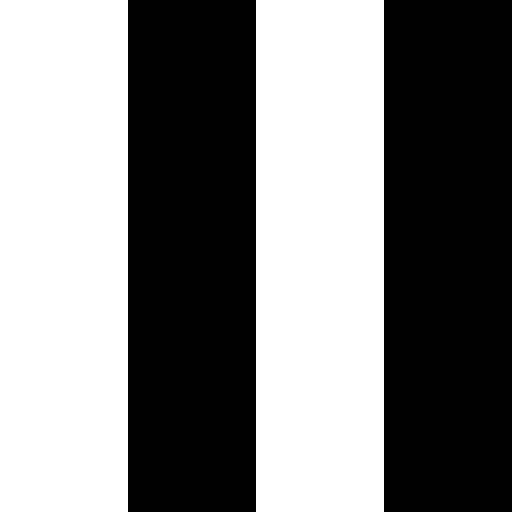

In [23]:
mask_index = 4
mask = Image.open(flist[mask_index])
mask

In [24]:
mask.size

(512, 512)

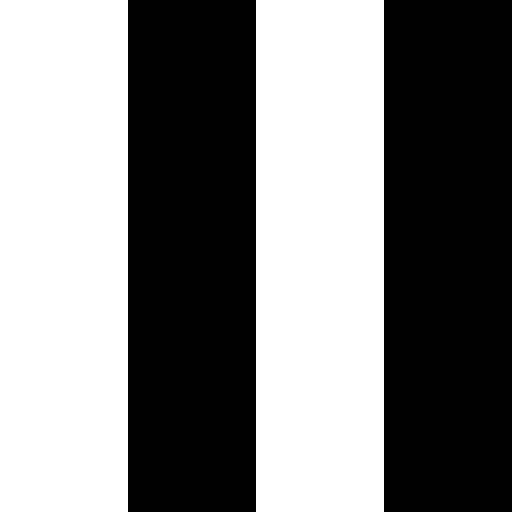

In [25]:
mask = transforms.Resize(config.INPUT_SIZE, interpolation=Image.NEAREST)(mask)
mask

In [26]:
mask.size

(512, 512)

In [27]:
mask_tens = transforms.ToTensor()(mask)
mask_tens

tensor([[[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]]])

In [28]:
mask_set

[tensor([[[1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          ...,
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.]]]),
 tensor([[[0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          ...,
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.]]]),
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]])]

In [29]:
config

Config (path: ./configs/config_mvtec.py): {'MODE': 1, 'MASK_TYPE': 3, 'SEED': 10, 'GPU': [0], 'DEBUG': 0, 'VERBOSE': 0, 'dataroot': './dataset/mvtec/bottle', 'workers': 4, 'normal_class': 'good', 'TRAIN_MASK_FLIST': './mask', 'TEST_MASK_FLIST': './mask', 'LR': 0.0001, 'D2G_LR': 0.1, 'BETA1': 0.0, 'BETA2': 0.9, 'BATCH_SIZE': 4, 'INPUT_SIZE': 512, 'INPUT_CHANNELS': 3, 'SCALES': [1, 2, 3], 'MAX_EPOCHS': 200, 'REC_LOSS_WEIGHT': 1, 'FM_LOSS_WEIGHT': 0, 'INPAINT_ADV_LOSS_WEIGHT': 0.001, 'GAN_LOSS': 'nsgan', 'LOG_INTERVAL': 10, 'STAGE': [1], 'DATASET': 'MVTecAD', 'SUB_SET': 'bottle', 'PATH': './ckpt/mvtec/bottle', 'DEVICE': device(type='cuda')}

In [42]:
opt = config
masks = AddMask(opt)

/home/sunwookim/.local/lib/python3.6/site-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [43]:
opt.normal_class

'good'

In [45]:
if opt.normal_class == '':
    opt.normal_class = opt.SUB_SET
# LOAD DATA SET
if opt.dataroot == '':
    opt.dataroot = './dataset/{}'.format(opt.DATASET)

opt.dataroot = './dataset/mvtec/bottle'

if opt.DATASET in ['MVTecAD']:
    # if opt.SUB_SET is not None:
    #     opt.dataroot = os.path.join(opt.dataroot, opt.SUB_SET)
    opt.dataroot = './dataset/mvtec/bottle'
    splits = ['train', 'test', 'train4val']
    splits2folder = {'train': 'train', 'test': 'test', 'train4val': 'train'}
    drop_last_batch = {'train': True, 'test': False, 'train4val': False}
    shuffle = {'train': True, 'test': False, 'train4val': False}
    transform = transforms.Compose([transforms.Resize(opt.INPUT_SIZE),
                                    transforms.CenterCrop(opt.INPUT_SIZE),
                                    transforms.ToTensor(), ])
                                    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), ])

    collate = {'train': masks.append_mask, 'test': masks.append_mask, 'train4val': masks.append_mask}
    dataset = {x: ImageFolder(os.path.join(opt.dataroot, splits2folder[x]), transform) for x in splits}


    dataset = {x: get_custom_anomaly_dataset(dataset[x], opt.normal_class) for x in dataset.keys()}
    # dataset['train4val'] = dataset['train']
    dataloader = {}
    for x in splits:
        if collate[x] is not None:
            dataloader[x] = torch.utils.data.DataLoader(dataset=dataset[x],
                                                        batch_size=opt.BATCH_SIZE,
                                                        shuffle=shuffle[x],
                                                        num_workers=int(opt.workers),
                                                        drop_last=drop_last_batch[x],
                                                        collate_fn=collate[x],
                                                        worker_init_fn=(None if opt.SEED == -1
                                                        else lambda x: np.random.seed(opt.SEED)))
        else:
            dataloader[x] = torch.utils.data.DataLoader(dataset=dataset[x],
                                                        batch_size=opt.BATCH_SIZE,
                                                        shuffle=shuffle[x],
                                                        num_workers=int(opt.workers),
                                                        drop_last=drop_last_batch[x],
                                                        worker_init_fn=(None if opt.SEED == -1
                                                                        else lambda x: np.random.seed(opt.SEED)))

In [46]:
collate

{'train': <bound method AddMask.append_mask of <__main__.AddMask object at 0x7fc601db5710>>,
 'test': <bound method AddMask.append_mask of <__main__.AddMask object at 0x7fc601db5710>>,
 'train4val': <bound method AddMask.append_mask of <__main__.AddMask object at 0x7fc601db5710>>}

In [47]:
dataset.keys()

dict_keys(['train', 'test', 'train4val'])

In [48]:
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fc6010bfeb8>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fc6010bff98>,
 'train4val': <torch.utils.data.dataloader.DataLoader at 0x7fc6010bf9b0>}

### ExpMvtec : Mask_loader

In [49]:
mask_set = BlockMask(config)

/home/sunwookim/.local/lib/python3.6/site-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [50]:
mask_loader = DataLoader(dataset=mask_set, batch_size=1)
mask_loader

In [51]:
len(mask_loader)

16

In [52]:
next(iter(mask_loader)) 

tensor([[[[1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          ...,
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.]]]])

In [53]:
masks = [x.to(config.DEVICE) for x in mask_loader]
masks

[tensor([[[[1., 1., 1.,  ..., 0., 0., 0.],
           [1., 1., 1.,  ..., 0., 0., 0.],
           [1., 1., 1.,  ..., 0., 0., 0.],
           ...,
           [1., 1., 1.,  ..., 0., 0., 0.],
           [1., 1., 1.,  ..., 0., 0., 0.],
           [1., 1., 1.,  ..., 0., 0., 0.]]]], device='cuda:0'),
 tensor([[[[0., 0., 0.,  ..., 1., 1., 1.],
           [0., 0., 0.,  ..., 1., 1., 1.],
           [0., 0., 0.,  ..., 1., 1., 1.],
           ...,
           [0., 0., 0.,  ..., 1., 1., 1.],
           [0., 0., 0.,  ..., 1., 1., 1.],
           [0., 0., 0.,  ..., 1., 1., 1.]]]], device='cuda:0'),
 tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0'),
 tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ...,

In [54]:
masks[0].shape

torch.Size([1, 1, 512, 512])

In [55]:
model_name = 'coarse'

results_path = os.path.join(config.PATH, 'results')
if hasattr(config, 'RESULTS'):
    results_path = os.path.join(config.RESULTS)

if hasattr(config, 'DEBUG') and config.DEBUG != 0:
    debug = True

log_file = os.path.join(config.PATH, 'log_' + model_name + '.dat')

In [56]:
dataset

{'train': Dataset ImageFolder
     Number of datapoints: 209
     Root location: ./dataset/mvtec/bottle/train
     StandardTransform
 Transform: Compose(
                Resize(size=512, interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(512, 512))
                ToTensor()
            ),
 'test': Dataset ImageFolder
     Number of datapoints: 83
     Root location: ./dataset/mvtec/bottle/test
     StandardTransform
 Transform: Compose(
                Resize(size=512, interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(512, 512))
                ToTensor()
            ),
 'train4val': Dataset ImageFolder
     Number of datapoints: 209
     Root location: ./dataset/mvtec/bottle/train
     StandardTransform
 Transform: Compose(
                Resize(size=512, interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(512, 512))
                ToTensor()
            )}

In [57]:
train_loader = dataset['train']
train_loader

Dataset ImageFolder
    Number of datapoints: 209
    Root location: ./dataset/mvtec/bottle/train
    StandardTransform
Transform: Compose(
               Resize(size=512, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(512, 512))
               ToTensor()
           )

In [58]:
len(train_loader)

209

## Train

In [59]:
model

In [60]:
model.dataset

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fc607468fd0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fc6637ca9e8>,
 'train4val': <torch.utils.data.dataloader.DataLoader at 0x7fc607468f28>}

In [61]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

def imshow(img):
    np_img = img.numpy()
    plt.imshow((np.transpose(np_img, (1,2,0))).shape)

In [62]:
train_loader = dataset['train']
dataiter = iter(train_loader)
imgs, labels = next(dataiter)
imgs.shape

torch.Size([3, 512, 512])

### Inpainting model

In [63]:
class BaseNetwork(nn.Module):
    def __init__(self):
        super(BaseNetwork, self).__init__()

    def init_weights(self, init_type='normal', gain=0.02):
        '''
        initialize network's weights
        init_type: normal | xavier | kaiming | orthogonal
        https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/9451e70673400885567d08a9e97ade2524c700d0/models/networks.py#L39
        '''
        def init_func(m):
            classname = m.__class__.__name__
            if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
                if init_type == 'normal':
                    nn.init.normal_(m.weight.data, 0.0, gain)
                elif init_type == 'xavier':
                    nn.init.xavier_normal_(m.weight.data, gain=gain)
                elif init_type == 'kaiming':
                    nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
                elif init_type == 'orthogonal':
                    nn.init.orthogonal_(m.weight.data, gain=gain)

                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.constant_(m.bias.data, 0.0)

            elif classname.find('BatchNorm2d') != -1:
                nn.init.normal_(m.weight.data, 1.0, gain)
                nn.init.constant_(m.bias.data, 0.0)

        self.apply(init_func)

class InpaintGenerator(BaseNetwork):
    def __init__(self, residual_blocks=8, init_weights=True, in_channels=3):
        super(InpaintGenerator, self).__init__()

        self.encoder = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=7, padding=0),
            nn.InstanceNorm2d(64, track_running_stats=False),
            nn.ReLU(True),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128, track_running_stats=False),
            nn.ReLU(True),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256, track_running_stats=False),
            nn.ReLU(True),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256, track_running_stats=False),
            nn.ReLU(True)
        )

        blocks = []
        for _ in range(residual_blocks):
            block = ResnetBlock(512, 2)  # dilation
            blocks.append(block)

        self.middle = nn.Sequential(*blocks)

        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(128, track_running_stats=False),
            nn.ReLU(True),

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(128, track_running_stats=False),
            nn.ReLU(True),

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(64, track_running_stats=False),
            nn.ReLU(True),

            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels=64, out_channels=in_channels, kernel_size=7, padding=0),
        )

        if init_weights:
            self.init_weights()

    def forward(self, x, mask=None):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        x = (torch.tanh(x) + 1) / 2
        return x

class Discriminator(BaseNetwork):
    def __init__(self, in_channels, use_sigmoid=True, use_spectral_norm=True, init_weights=True):
        super(Discriminator, self).__init__()
        self.use_sigmoid = use_sigmoid

        self.conv1 = self.features = nn.Sequential(
            spectral_norm(nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=4, stride=2, padding=1, bias=not use_spectral_norm), use_spectral_norm),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.conv2 = nn.Sequential(
            spectral_norm(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=not use_spectral_norm), use_spectral_norm),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.conv3 = nn.Sequential(
            spectral_norm(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=not use_spectral_norm), use_spectral_norm),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.conv4 = nn.Sequential(
            spectral_norm(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=1, padding=1, bias=not use_spectral_norm), use_spectral_norm),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.conv5 = nn.Sequential(
            spectral_norm(nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=1, bias=not use_spectral_norm), use_spectral_norm),
        )

        if init_weights:
            self.init_weights()

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)

        outputs = conv5
        if self.use_sigmoid:
            outputs = torch.sigmoid(conv5)

        return outputs, [conv1, conv2, conv3, conv4, conv5]

class ResnetBlock(nn.Module):
    def __init__(self, dim, dilation=1, use_spectral_norm=False):
        super(ResnetBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.ReflectionPad2d(dilation),
            spectral_norm(nn.Conv2d(in_channels=dim, out_channels=dim, kernel_size=3, padding=0, dilation=dilation, bias=not use_spectral_norm), use_spectral_norm),
            # spectral_norm(nn.Conv2d(in_channels=dim, out_channels=dim, kernel_size=3, padding=1, bias=not use_spectral_norm), use_spectral_norm),
            nn.InstanceNorm2d(dim, track_running_stats=False),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            spectral_norm(nn.Conv2d(in_channels=dim, out_channels=dim, kernel_size=3, padding=0, dilation=1, bias=not use_spectral_norm), use_spectral_norm),
            # spectral_norm(nn.Conv2d(in_channels=dim, out_channels=dim, kernel_size=3, padding=1, bias=not use_spectral_norm), use_spectral_norm),
            nn.InstanceNorm2d(dim, track_running_stats=False),
        )

    def forward(self, x):
        out = x + self.conv_block(x)
        # Remove ReLU at the end of the residual block
        # http://torch.ch/blog/2016/02/04/resnets.html
        return out

def spectral_norm(module, mode=True):
    if mode:
        return nn.utils.spectral_norm(module)
    return module

In [64]:
import torch.optim as optim
from src.loss import AdversarialLoss

class BaseModel(nn.Module):
    def __init__(self, name, config):
        super(BaseModel, self).__init__()

        self.name = name
        self.config = config
        self.iteration = 0
        self.epoch = 0

        self.gen_weights_path = os.path.join(config.PATH, name + '_gen.pth')
        self.dis_weights_path = os.path.join(config.PATH, name + '_dis.pth')

    def load(self):
        if os.path.exists(self.gen_weights_path):
            print('Loading %s generator...' % self.name)

            if torch.cuda.is_available():
                data = torch.load(self.gen_weights_path)
            else:
                data = torch.load(self.gen_weights_path, map_location=lambda storage, loc: storage)

            self.generator.load_state_dict(data['generator'])
            self.iteration = data['iteration']
            self.epoch = data['epoch']

        # load discriminator only when training
        if self.config.MODE == 1 and os.path.exists(self.dis_weights_path):
            print('Loading %s discriminator...' % self.name)

            # update weights
            if torch.cuda.is_available():
                data = torch.load(self.dis_weights_path)
            else:
                data = torch.load(self.dis_weights_path, map_location=lambda storage, loc: storage)

            self.discriminator.load_state_dict(data['discriminator'])

    def save(self):
        print('\nsaving %s...\n' % self.name)
        torch.save({
            'iteration': self.iteration,
            'epoch': self.epoch,
            'generator': self.generator.state_dict()
        }, self.gen_weights_path)

        torch.save({
            'discriminator': self.discriminator.state_dict()
        }, self.dis_weights_path)

class InpaintingModel(BaseModel):

    def __init__(self, config, append_name=''):
        super(InpaintingModel, self).__init__('InpaintingModel'+str(append_name), config)

        # generator input: [rgb(3)]
        # discriminator input: [rgb(3)]
        generator = InpaintGenerator(in_channels=config.INPUT_CHANNELS)

        discriminator = Discriminator(in_channels=config.INPUT_CHANNELS, use_sigmoid=config.GAN_LOSS != 'hinge')


        if len(config.GPU) > 1:
            generator = nn.DataParallel(generator, config.GPU)
            discriminator = nn.DataParallel(discriminator, config.GPU)

        l1_loss = nn.MSELoss()
        adversarial_loss = AdversarialLoss(type=config.GAN_LOSS)

        self.add_module('generator', generator)
        self.add_module('discriminator', discriminator)

        self.add_module('l1_loss', l1_loss)
        self.add_module('adversarial_loss', adversarial_loss)

        self.gen_optimizer = optim.Adam(
            params=generator.parameters(),
            lr=float(config.LR),
            betas=(config.BETA1, config.BETA2)
        )

        self.dis_optimizer = optim.Adam(
            params=discriminator.parameters(),
            lr=float(config.LR) * float(config.D2G_LR),
            betas=(config.BETA1, config.BETA2)
        )

    def process(self, images, masks=None):
        self.iteration += 1

        # zero optimizers
        self.gen_optimizer.zero_grad()
        self.dis_optimizer.zero_grad()

        # process outputs
        outputs = self(images, masks)
        gen_loss = 0
        dis_loss = 0

        # discriminator loss
        dis_input_real = images
        dis_input_fake = outputs.detach()
        dis_real, dis_real_feat = self.discriminator(dis_input_real)                    # in: [rgb(3)]
        dis_fake, _ = self.discriminator(dis_input_fake)                    # in: [rgb(3)]
        dis_real_loss = self.adversarial_loss(dis_real, True, True)
        dis_fake_loss = self.adversarial_loss(dis_fake, False, True)
        dis_loss += (dis_real_loss + dis_fake_loss) / 2

        # generator adversarial loss
        gen_input_fake = outputs
        gen_fake, gen_fake_feat = self.discriminator(gen_input_fake)                    # in: [rgb(3)]
        gen_gan_loss = self.adversarial_loss(gen_fake, True, False) * self.config.INPAINT_ADV_LOSS_WEIGHT
        gen_loss += gen_gan_loss

        # generator l1 loss
        if masks is not None:
            gen_l1_loss_back = self.l1_loss(outputs*(1-masks).float(), images*(1-masks).float())
            gen_l1_loss_crop = self.l1_loss(outputs*masks.float(), images*masks.float())
            gen_l1_loss = (gen_l1_loss_back + 4 * gen_l1_loss_crop) * self.config.REC_LOSS_WEIGHT / torch.mean(masks)
        else:
            gen_l1_loss = self.l1_loss(outputs, images) * self.config.REC_LOSS_WEIGHT
        gen_loss += gen_l1_loss

        # generator feature matching loss
        gen_fm_loss = 0
        for i in range(len(dis_real_feat)):
            gen_fm_loss += nn.MSELoss()(gen_fake_feat[i], dis_real_feat[i].detach())
        gen_fm_loss = gen_fm_loss * self.config.FM_LOSS_WEIGHT
        gen_loss += gen_fm_loss

        logs = {
            "l_dis": dis_loss.item(),
            "l_dis_real": dis_real_loss.item(),
            "l_dis_fake": dis_fake_loss.item(),
            "l_gen_gan": gen_gan_loss.item(),
            "l_l1": gen_l1_loss.item(),
            "l_fm": gen_fm_loss.item(),
            "l_gen_sum": gen_loss.item(),
        }

        return outputs, gen_loss, dis_loss, logs

    def forward(self, images, masks=None):
        if masks is not None:
            images_masked = (images * (1 - masks).float()) + masks
            inputs = images_masked
            if masks.size(0) == 1:
                masks = masks.expand(inputs.size()[0], -1, -1, -1)
            outputs = self.generator(inputs, masks)  # in: [rgb(3)]
        else:
            inputs = images
            outputs = self.generator(inputs)                                    # in: [rgb(3)]
        return outputs

    def backward(self, gen_loss=None, dis_loss=None):
        dis_loss.backward()
        self.dis_optimizer.step()

        gen_loss.backward()
        self.gen_optimizer.step()

In [65]:
model.inpaint_model

InpaintingModel(
  (generator): InpaintGenerator(
    (encoder): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
      (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (3): ReLU(inplace=True)
      (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (11): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (12): ReLU(inplace=True)
    )
    (middle): Sequential(
      (0): ResnetBlock(
        (conv_block)

In [66]:
model.inpaint_model.generator

InpaintGenerator(
  (encoder): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (11): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (12): ReLU(inplace=True)
  )
  (middle): Sequential(
    (0): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((2, 2, 2, 2))
        (1)

In [67]:
model.inpaint_model.discriminator

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv5): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
)

In [68]:
model.eval()



val:
209/209 [====================] - 108s 517ms/step - index: 25.6268


0.41785451769828796

In [69]:
model.test()



test:
83/83 [====================] - 44s 531ms/step - index: 9.8795
0.2238095238095238


0.2238095238095238

## Test

In [71]:
config.MODE = 2

model.update_norm()
print('\nstart testing...\n')
model.test()



update normalization parameter:
209/209 [====================] - 110s 528ms/step - index: 25.6268
updated norm: [0.22931867837905884, 0.2315831184387207, 0.2428763061761856]

start testing...



test:
83/83 [====================] - 45s 537ms/step - index: 9.8795
0.27063492063492056


0.27063492063492056

In [76]:
def update_norm(self):
    print('\n\nupdate normalization parameter:')
    val_loader = self.dataset['train4val']

    total = len(val_loader.dataset)
    self.inpaint_model.eval()

    mean_error_scales = {str(i): 0 for i in self.config.SCALES}
    progbar = Progbar(total, width=20, stateful_metrics=['it'])
    for index, items in enumerate(val_loader):
        images, masks = self.cuda(*items[0:2])
        # inpaint model
        error1_list, mix_out_list_x, mix_out_list_y = self.get_error_map_for_some_scales(images, self.masks, metric='MSE',
                                                                        scales=self.config.SCALES, output=True)
        for i, scale in enumerate(self.config.SCALES):
            mean_error_scales[str(scale)] += torch.mean(error1_list[i]) * len(items[0]) / total
        progbar.add(len(images), values=[('index', index)])
    # update
    for i, scale in enumerate(self.config.SCALES):
        self.scale_norm[i] = mean_error_scales[str(scale)].item()
    print('updated norm:', self.scale_norm)

In [77]:
def get_error_map_for_some_scales(self, images, mask_loader, metric='MSE', scales=None, output=False):
    if metric == 'MSE':
        error_metric = nn.MSELoss(reduction='none')
    else:
        error_metric = nn.L1Loss(reduction='none')
    with torch.no_grad():
        error_map_list = []
        mix_output_x = []
        mix_output_y = []
        for scale in scales:
            error = []
            raw_output = []
            for masks in mask_loader[scale*4:(scale+1)*4]:
                outputs = self.inpaint_model(images, masks)
                if output:
                    raw_output.append(outputs*masks)
                error.append(torch.mean(error_metric(outputs, images) * masks, 1))  # mean RGB channel
            if output:
                raw_output = torch.stack(raw_output)
                mix_output_x.append(torch.sum(raw_output[0:2], 0))
                mix_output_y.append(torch.sum(raw_output[2:4], 0))
            error = torch.stack(tuple(error))
            # error_map_list.append(torch.sum(error * 0.5, 0))
            error_map_list.append(torch.max(error, 0)[0])

    return error_map_list, mix_output_x, mix_output_y